In [1]:
import sys,os,time
import pandas as pd
import numpy as np
from numba import jit
import numba as nb
from tqdm.notebook import tqdm

#--matplotlib
import matplotlib
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
matplotlib.rc('text',usetex=True)
import pylab  as py
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d
from IPython.display import clear_output

#--torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist

ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
torch.set_default_tensor_type(torch.cuda.DoubleTensor if torch.cuda.is_available() else torch.DoubleTensor)
dtype = torch.float64

/opt/conda/lib/python3.11/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [2]:
import lhapdf
# path="/w/jam-sciwork24/apps/lhapdf_tables:/w/jam-sciwork24/share/replicas"
path="/w/jam-sciwork24/dadamiak/ePump/ePump_kp20221218/lattice_moment_test1/:/w/jam-sciwork24/share/replicas"
os.environ["LHAPDF_DATA_PATH"] = path

CT = lhapdf.getPDFSet("CT18NNLO")
pdf=CT.mkPDFs()

LHAPDF 6.5.4 loading all 59 PDFs in set CT18NNLO
CT18NNLO, version 1; 59 PDF members


In [3]:
len(pdf)

59

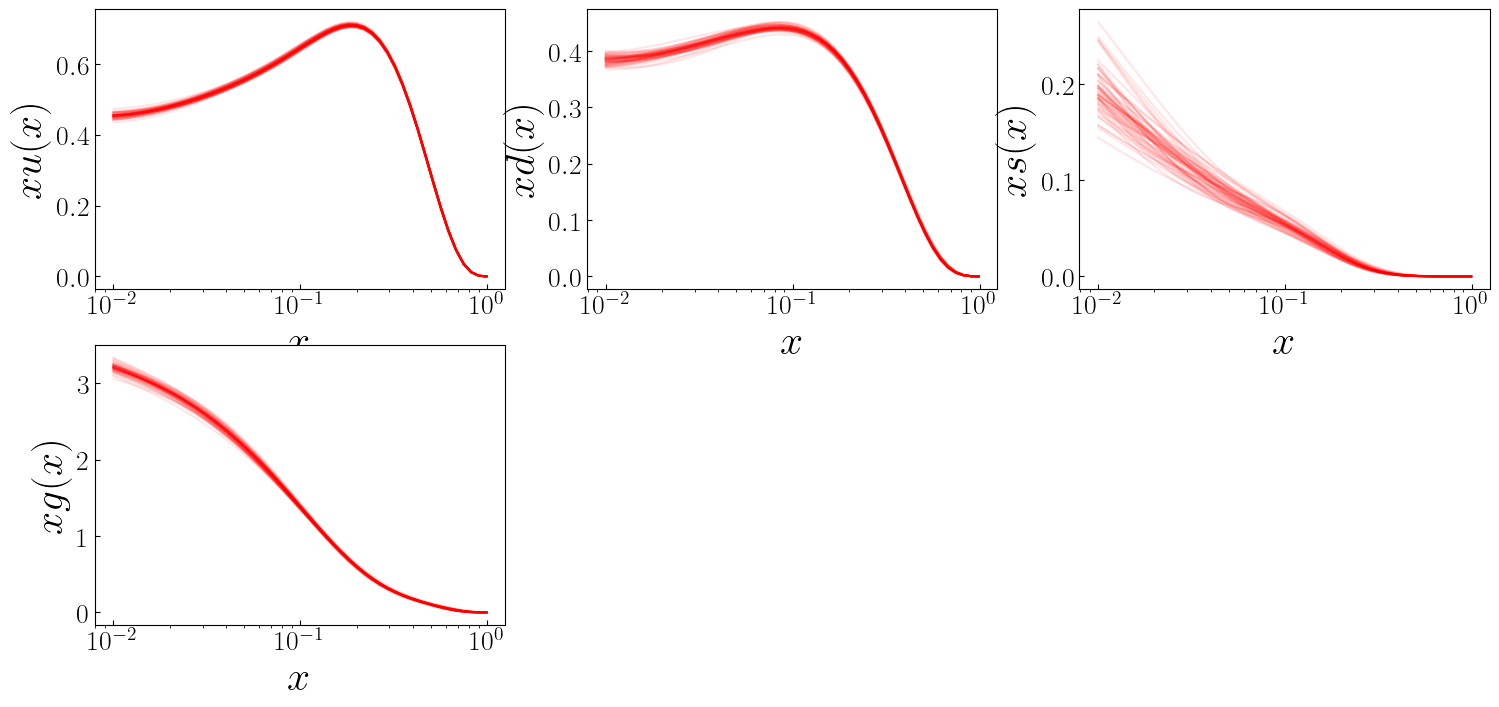

In [4]:
nrows,ncols=2,3; AX={}
fig = py.figure(figsize=(ncols*6,nrows*4))

x=10**np.linspace(-2,np.log10(0.99))
Q2=4

cnt=1
ax=py.subplot(nrows,ncols,cnt);AX[cnt]=ax
for iset in range(len(pdf[:100])):
    ax.plot(x,[pdf[iset].xfxQ2(2,_,Q2) for _ in x],'r-',alpha=0.1)
    ax.set_ylabel(r'$xu(x)$',size=30) 

cnt+=1
ax=py.subplot(nrows,ncols,cnt);AX[cnt]=ax
for iset in range(len(pdf[:100])):
    ax.plot(x,[pdf[iset].xfxQ2(1,_,Q2) for _ in x],'r-',alpha=0.1)
    ax.set_ylabel(r'$xd(x)$',size=30) 

cnt+=1
ax=py.subplot(nrows,ncols,cnt);AX[cnt]=ax
for iset in range(len(pdf[:100])):
    ax.plot(x,[pdf[iset].xfxQ2(3,_,Q2) for _ in x],'r-',alpha=0.1)
    ax.set_ylabel(r'$xs(x)$',size=30) 
    
cnt+=1
ax=py.subplot(nrows,ncols,cnt);AX[cnt]=ax
for iset in range(len(pdf[:100])):
    ax.plot(x,[pdf[iset].xfxQ2(21,_,Q2) for _ in x],'r-',alpha=0.1)
    ax.set_ylabel(r'$xg(x)$',size=30) 
    
for _ in AX:    
    ax=AX[_]
    ax.semilogx()
    ax.set_xlabel(r'$x$',size=30)  
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')

In [5]:
def M(x,xg):
    x_ = torch.tensor(x)
    f_ = torch.tensor(xg)
    Mtotal = torch.trapz(f_,x_)
    return Mtotal

In [6]:
Ms = []
for i in range(len(pdf)):
    m = [pdf[i].xfxQ2(2,_,Q2)-pdf[i].xfxQ2(1,_,Q2) for _ in x] #computing u-d moment
    Ms.append(M(x,m).cpu().detach().numpy())
Ms = np.array(Ms)
if len(Ms.shape)==1:
    Ms = np.expand_dims(Ms,1)

(array([ 2.,  4.,  4.,  5., 22.,  9.,  6.,  4.,  0.,  3.]),
 array([0.15835997, 0.15932129, 0.16028261, 0.16124393, 0.16220525,
        0.16316657, 0.16412788, 0.1650892 , 0.16605052, 0.16701184,
        0.16797316]),
 <BarContainer object of 10 artists>)

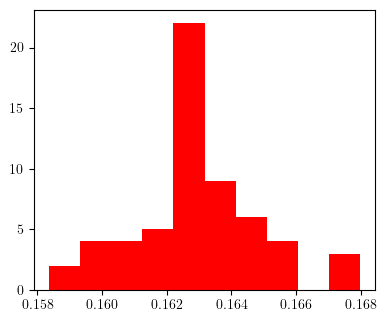

In [7]:
fig = py.figure(figsize=(ncols*5,nrows*4))
ax=py.subplot(nrows,ncols,1);
ax.hist(Ms,bins=10,color='red')

In [8]:
uncert = CT.uncertainty(Ms)
uncert.central

/scratch/slurm/58882712/.cache/tmp/ipykernel_358056/938336360.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  uncert = CT.uncertainty(Ms)


0.16289644366040607

In [9]:
uncert.errplus

0.006433877411399631

In [10]:
uncert.errminus

0.006275682062967916

# Save theory file

In [11]:

def save_theory(pdf,Q2,name='test'):
    
    Ms = []
    for i in range(len(pdf)):
        m = [pdf[i].xfxQ2(2,_,Q2)-pdf[i].xfxQ2(1,_,Q2) for _ in x] #computing u-d moment
        Ms.append(M(x,m).cpu().detach().numpy())
    Ms = np.array(Ms)
    if len(Ms.shape)==1:
        Ms = np.expand_dims(Ms,1)
    n, m = Ms.shape
    
    with open("%s.theory"%name, "w") as f:
        # First three lines, each with '*'
        f.write("*\n*\n*\n")
        
        # "theory column"
        f.write("Theory column\n")
        
        # m value
        f.write(f"{m}\n")
        
        # Loop over each row
        for i in range(n):
            f.write(f"PDF_{i}_Set\n")
            # Each number: width=12, 6 decimal places, right aligned
            formatted_row = "".join(f"{val:12.6f}" for val in Ms[i])
            f.write(formatted_row + "\n")

save_theory(pdf,4,"CT18NNLO_mom_test1")

# Update PDFs V2

In [12]:
def updatePDFs(pdf, data):
    PDFs = []
    CTs  = []
    for dataset in data:
        #write to data file
        # your array
        arr = dataset
        # convert to space-separated string with a newline
        new_line = " ".join(map(str, arr)) + "\n"
        filename = "CT18NNLO_mom_test1"
        save_theory(pdf,dataset[1],filename)
        # read all lines
        with open("%s.data"%filename, "r") as f:
            lines = f.readlines()
        # replace the last line
        lines[-1] = new_line
        # write back
        with open("%s.data"%filename, "w") as f:
            f.writelines(lines)
        #update PDFs
        !../src/UpdatePDFs CT18NNLO_mom_test1
        clear_output(wait=False)
        CT_temp = lhapdf.getPDFSet(filename)
        pdf_temp=CT_temp.mkPDFs()
        PDFs.append(pdf_temp)
        CTs.append(CT_temp)
    return PDFs, CTs

In [13]:
#First, we create some pseudo data
# my_data = [[0.5, 0.774, 0.082, 0, 0]]
# my_data = [[0.5, 0.774, 0.0082, 0, 0], [0.5, 1.774, 0.0082, 0, 0], [0.5, 2.5, 0.005, 0, 0]]
my_data = [[0.5, 2, 0.151, 0.0005, 0, 0], 
           [0.5, 2, 0.153, 0.0013, 0, 0],
           [0.5, 4, 0.206, 0.0006, 0, 0], 
           [0.5, 2, 0.141, 0.0008, 0, 0], 
           [0.5, 2, 0.267, 0.0017, 0, 0],
           [0.5, 2, 0.191, 0.0014, 0, 0], 
           [0.5, 2, 0.269, 0.0025, 0, 0], 
           [0.5, 2, 0.280, 0.0010, 0, 0]]
data_labels = ["NNPDF4","FLAG","QCDSF","Hadstruc","Bhattacharya et al","Gao et al","Bhat et al", "Alexandrou et al"]

In [14]:
PDFs, CTs = updatePDFs(pdf,my_data)

LHAPDF 6.5.4 loading all 59 PDFs in set CT18NNLO_mom_test1
CT18NNLO_mom_test1, version 1; 59 PDF members


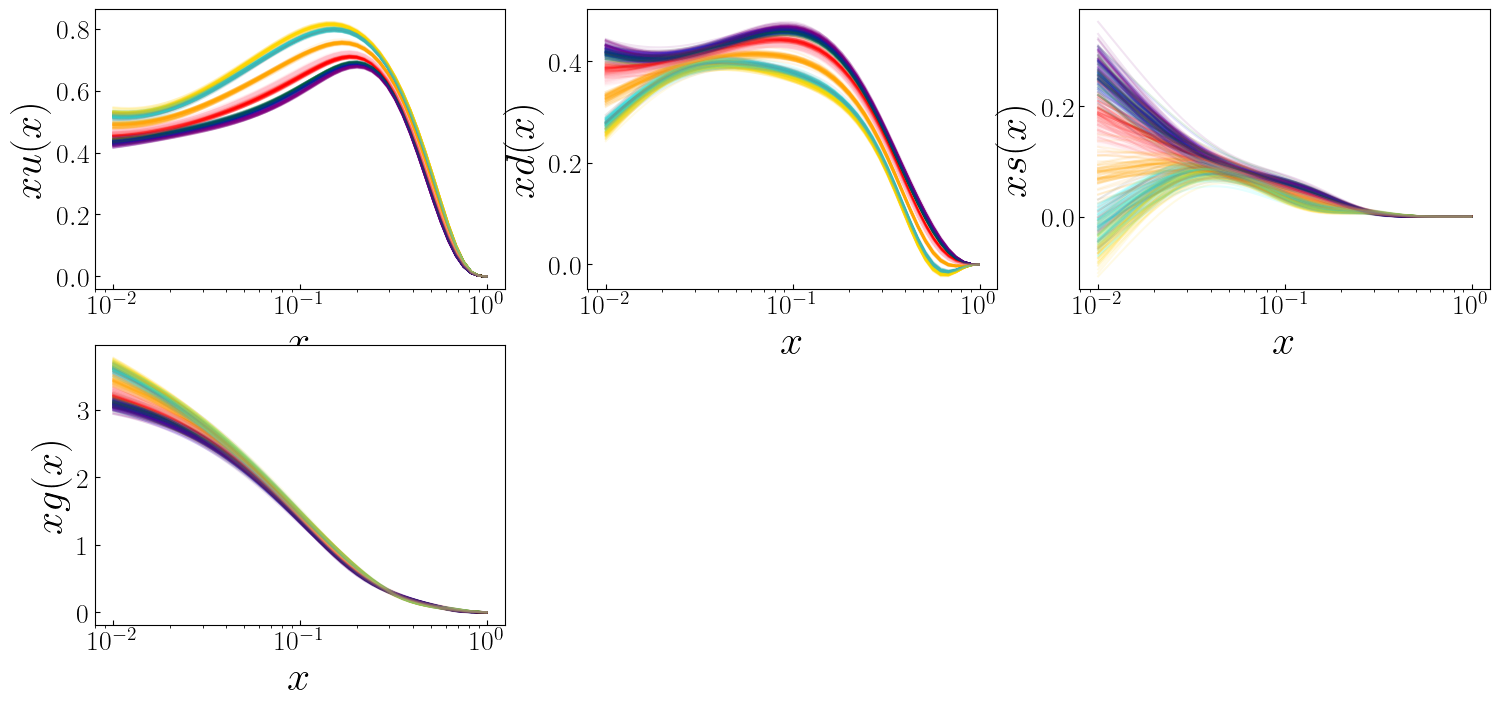

In [15]:
#Plotting new PDFs
nrows,ncols=2,3; AX={}
fig = py.figure(figsize=(ncols*6,nrows*4))

x=10**np.linspace(-2,np.log10(0.99))
Q2=4
colors = ['b','g','orange','purple','cyan','pink','grey','gold']

cnt=1
ax=py.subplot(nrows,ncols,cnt);AX[cnt]=ax
for iset in range(len(pdf[:100])):
    ax.plot(x,[pdf[iset].xfxQ2(2,_,Q2) for _ in x],'r-',alpha=0.1)
    for i in range(len(PDFs)):
        ax.plot(x,[PDFs[i][iset].xfxQ2(2,_,Q2) for _ in x],'-',color=colors[i],alpha=0.1)
    ax.set_ylabel(r'$xu(x)$',size=30) 

cnt+=1
ax=py.subplot(nrows,ncols,cnt);AX[cnt]=ax
for iset in range(len(pdf[:100])):
    ax.plot(x,[pdf[iset].xfxQ2(1,_,Q2) for _ in x],'r-',alpha=0.1)
    for i in range(len(PDFs)):
        ax.plot(x,[PDFs[i][iset].xfxQ2(1,_,Q2) for _ in x],'-',color=colors[i],alpha=0.1)
    ax.set_ylabel(r'$xd(x)$',size=30) 

cnt+=1
ax=py.subplot(nrows,ncols,cnt);AX[cnt]=ax
for iset in range(len(pdf[:100])):
    ax.plot(x,[pdf[iset].xfxQ2(3,_,Q2) for _ in x],'r-',alpha=0.1)
    for i in range(len(PDFs)):
        ax.plot(x,[PDFs[i][iset].xfxQ2(3,_,Q2) for _ in x],'-',color=colors[i],alpha=0.1)
    ax.set_ylabel(r'$xs(x)$',size=30) 
    
cnt+=1
ax=py.subplot(nrows,ncols,cnt);AX[cnt]=ax
for iset in range(len(pdf[:100])):
    ax.plot(x,[pdf[iset].xfxQ2(21,_,Q2) for _ in x],'r-',alpha=0.1)
    for i in range(len(PDFs)):
        ax.plot(x,[PDFs[i][iset].xfxQ2(21,_,Q2) for _ in x],'-',color=colors[i],alpha=0.1)
    ax.set_ylabel(r'$xg(x)$',size=30) 
    
for _ in AX:    
    ax=AX[_]
    ax.semilogx()
    ax.set_xlabel(r'$x$',size=30)  
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')

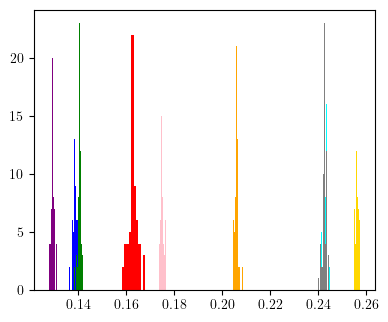

In [16]:
Ms_update = []
for j in range(len(PDFs)):
    Ms1 = []
    for i in range(len(PDFs[j])):
        m = [PDFs[j][i].xfxQ2(2,_,Q2)-PDFs[j][i].xfxQ2(1,_,Q2) for _ in x] #computing u-d moment
        Ms1.append(M(x,m).cpu().detach().numpy())
    Ms1 = np.array(Ms1)
    if len(Ms1.shape)==1:
        Ms1 = np.expand_dims(Ms1,1)
    Ms_update.append(Ms1)

fig = py.figure(figsize=(ncols*5,nrows*4))
ax=py.subplot(nrows,ncols,1);
ax.hist(Ms,bins=10, color = 'red')
for i in range(len(Ms_update)):
    ax.hist(Ms_update[i],bins=10,color=colors[i])

In [17]:
uncert = CT.uncertainty(Ms)
print('Original moment   = %3f +- %3f'%(uncert.central,uncert.errplus))

for i in range(len(CTs)):
    uncert1 = CTs[i].uncertainty(Ms_update[i])
    if uncert.central+uncert.errplus < uncert1.central-uncert1.errplus or uncert.central-uncert.errplus > uncert1.central+uncert1.errplus:
        print('\033[0;31mUpdated  moment_%s = %3f +- %3f\033[0m'%(i, uncert1.central,uncert1.errplus))
    else:
        print('Updated  moment_%s = %3f +- %3f'%(i, uncert1.central,uncert1.errplus))
        
    

Original moment   = 0.162896 +- 0.006434
Updated  moment_0 = 0.138572 +- 0.001758
Updated  moment_1 = 0.140683 +- 0.001570
Updated  moment_2 = 0.205837 +- 0.001977
Updated  moment_3 = 0.129544 +- 0.001694
Updated  moment_4 = 0.242758 +- 0.001895
Updated  moment_5 = 0.174958 +- 0.002017
Updated  moment_6 = 0.242242 +- 0.002454
Updated  moment_7 = 0.255890 +- 0.001818


/scratch/slurm/58882712/.cache/tmp/ipykernel_358056/1576056727.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  uncert = CT.uncertainty(Ms)
/scratch/slurm/58882712/.cache/tmp/ipykernel_358056/1576056727.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  uncert1 = CTs[i].uncertainty(Ms_update[i])
